In [3]:
!pip install mlxtend


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

# Load data from local CSV files
orders = pd.read_csv('Machine learning/philkiiru_orders.csv')
trees = pd.read_csv('Machine learning/treez.csv.csv', low_memory=False)
print('Orders preview:')
print(orders.head())
print('\nTrees preview:')
print(trees.head())

Orders preview:
   ORDER_ID  BUYER_ID  TOTAL_PRICE ORDER_STATUS           ORDER_DATE  \
0         6         6       6600.0      PENDING  2025-10-02 05:02:38   
1         7         6      10120.0    CANCELLED  2025-10-02 05:10:31   
2        23         6       1540.0      PENDING  2025-11-25 06:08:58   
3        39         6       3300.0      PENDING  2025-11-25 06:15:47   
4        40         6       2850.0      PENDING  2025-11-25 06:16:04   

         COMMON_NAME  
0   Honeylocust tree  
1   Honeylocust tree  
2   Honeylocust tree  
3   Honeylocust tree  
4   Honeylocust tree  

Trees preview:
  most_recent_observation most_recent_observation_type  common_name  \
0               6/17/2020               inventory_date       Locust   
1              06/09/2020               inventory_date          Oak   
2              06/03/2020               inventory_date          Ash   
3              06/03/2020               inventory_date  Scotch pine   
4               5/29/2020               in

In [5]:
import re


def normalize_name(s):
	if pd.isna(s): return ""
	return re.sub(r"[^\w\s]", "", str(s).lower().strip())


kaggle_common_col = [c for c in trees.columns if "common" in c.lower()][0]


trees["common_norm"] = trees[kaggle_common_col].apply(normalize_name)
orders["common_norm"] = orders["COMMON_NAME"].apply(normalize_name)


# Add any missing trees from orders into trees DataFrame (with placeholder info)
missing_trees = set(orders['common_norm']) - set(trees['common_norm'])
print(f"Missing trees in trees DataFrame: {missing_trees}")
if missing_trees:
	# Add a row for each missing tree with placeholder values for other columns
	for tree in missing_trees:
		placeholder = {col: '' for col in trees.columns}
		placeholder['common_norm'] = tree
		trees = pd.concat([trees, pd.DataFrame([placeholder])], ignore_index=True)
	print(f"Added {len(missing_trees)} missing trees to trees DataFrame.")
else:
	print("No missing trees to add.")


valid_names = set(trees["common_norm"])
orders = orders[orders["common_norm"].isin(valid_names)]


print("✅ Filtered orders:", len(orders))
print(orders.head())

Missing trees in trees DataFrame: {'acacia', 'eucalyptus', 'grevillea', 'cypress', 'jacaranda', 'honeylocust tree', 'flame tree', 'pinus'}
Added 8 missing trees to trees DataFrame.
✅ Filtered orders: 294
   ORDER_ID  BUYER_ID  TOTAL_PRICE ORDER_STATUS           ORDER_DATE  \
0         6         6       6600.0      PENDING  2025-10-02 05:02:38   
1         7         6      10120.0    CANCELLED  2025-10-02 05:10:31   
2        23         6       1540.0      PENDING  2025-11-25 06:08:58   
3        39         6       3300.0      PENDING  2025-11-25 06:15:47   
4        40         6       2850.0      PENDING  2025-11-25 06:16:04   

         COMMON_NAME       common_norm  
0   Honeylocust tree  honeylocust tree  
1   Honeylocust tree  honeylocust tree  
2   Honeylocust tree  honeylocust tree  
3   Honeylocust tree  honeylocust tree  
4   Honeylocust tree  honeylocust tree  


In [6]:
transactions = orders.groupby("ORDER_ID")["common_norm"].apply(list).tolist()
print("Sample transaction baskets:")
for t in transactions[:5]:
    print(t)

Sample transaction baskets:
['austrian pine', 'deodar cedar', 'grevillea', 'london plane', 'texas red oak']
['crabapple', 'cypress', 'desert willow', 'siberian elm']
['crabapple']
['honeylocust tree', 'austrian pine', 'bur oak', 'cottonwood', 'crabapple', 'deodar cedar', 'flame tree', 'siberian elm', 'texas red oak']
['honeylocust tree', 'austrian pine', 'bur oak', 'crabapple', 'deodar cedar', 'desert willow', 'flame tree', 'grevillea', 'london plane', 'siberian elm', 'texas red oak']


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_enc = pd.DataFrame(te_ary, columns=te.columns_)

min_support = 0.01 
min_confidence = 0.1

frequent_itemsets = apriori(df_enc, min_support=min_support, use_colnames=True)
if frequent_itemsets.empty:
    print(f"⚠️ No frequent itemsets found with min_support={min_support}. Try lowering it further or check your data.")
    rules = pd.DataFrame()
    strong_rules = pd.DataFrame()
else:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    if rules.empty:
        print(f"⚠️ No association rules found with min_confidence={min_confidence}. Try lowering it further.")
        strong_rules = pd.DataFrame()
    else:
        strong_rules = rules[(rules["confidence"] >= 0.7) & (rules["lift"] > 1)]
        print("✅ Strong rules found:", len(strong_rules))
        print(strong_rules[["antecedents","consequents","support","confidence","lift"]].head(10))

✅ Strong rules found: 3722
                       antecedents      consequents  support  confidence  \
167               (ponderosa pine)    (scotch pine)    0.024        0.75   
172           (bur oak, crabapple)  (austrian pine)    0.024        0.75   
173       (bur oak, austrian pine)      (crabapple)    0.024        1.00   
184          (bur oak, flame tree)  (austrian pine)    0.016        1.00   
186    (flame tree, austrian pine)        (bur oak)    0.016        1.00   
190    (bur oak, honeylocust tree)  (austrian pine)    0.016        1.00   
196        (siberian elm, bur oak)  (austrian pine)    0.016        1.00   
197  (siberian elm, austrian pine)        (bur oak)    0.016        1.00   
208      (crabapple, deodar cedar)  (austrian pine)    0.016        1.00   
215    (flame tree, austrian pine)      (crabapple)    0.016        1.00   

          lift  
167  10.416667  
172   6.696429  
173  10.416667  
184   8.928571  
186  10.416667  
190   8.928571  
196   8.928571  


In [8]:
def recommend(tree, rules_df=strong_rules, top_n=5):
    recs = rules_df[rules_df['antecedents'].apply(lambda x: tree in x)]
    if recs.empty:
        print(f"No recommendations for {tree}")
        return
    recs = recs.sort_values(by=["confidence","lift"], ascending=False)
    for _, r in recs.head(top_n).iterrows():
        print(f"💡 If buyer gets {list(r['antecedents'])} → recommend {list(r['consequents'])} "
              f"(conf={r['confidence']:.2f}, lift={r['lift']:.2f})")

# for instance
recommend("crabapple")


💡 If buyer gets ['crabapple', 'deodar cedar'] → recommend ['flame tree', 'austrian pine'] (conf=1.00, lift=62.50)
💡 If buyer gets ['crabapple', 'deodar cedar'] → recommend ['siberian elm', 'austrian pine'] (conf=1.00, lift=62.50)
💡 If buyer gets ['crabapple', 'deodar cedar'] → recommend ['bur oak', 'flame tree'] (conf=1.00, lift=62.50)
💡 If buyer gets ['crabapple', 'deodar cedar'] → recommend ['bur oak', 'honeylocust tree'] (conf=1.00, lift=62.50)
💡 If buyer gets ['crabapple', 'deodar cedar'] → recommend ['siberian elm', 'bur oak'] (conf=1.00, lift=62.50)


In [ ]:
export_cols = ["antecedents", "consequents", "support", "confidence", "lift"]
rules_to_export = rules.copy()
rules_to_export["antecedents"] = rules_to_export["antecedents"].apply(lambda x: ', '.join(list(x)))
rules_to_export["consequents"] = rules_to_export["consequents"].apply(lambda x: ', '.join(list(x)))
rules_to_export[export_cols].to_csv("ml/recommendations.csv", index=False)
print("Exported recommendations to ml/recommendations.csv")

Exported recommendations to ml/recommendations.csv


In [ ]:
import os

uploads_dir = 'uploads'
upload_files = os.listdir(uploads_dir)

import difflib
def find_best_image(tree_name, files):
    tree_name = tree_name.lower().replace(' ', '')
    candidates = [f for f in files if tree_name in f.lower().replace(' ', '')]
    if candidates:
        return os.path.join(uploads_dir, candidates[0])
    
    match = difflib.get_close_matches(tree_name, [f.lower().replace(' ', '') for f in files], n=1)
    if match:
        idx = [f.lower().replace(' ', '') for f in files].index(match[0])
        return os.path.join(uploads_dir, files[idx])
    return ''

rules_to_export = rules.copy()
rules_to_export["antecedents"] = rules_to_export["antecedents"].apply(lambda x: ', '.join(list(x)))
rules_to_export["consequents"] = rules_to_export["consequents"].apply(lambda x: ', '.join(list(x)))
rules_to_export["consequent_image"] = rules_to_export["consequents"].apply(lambda x: find_best_image(x, upload_files))
export_cols = ["antecedents", "consequents", "consequent_image", "support", "confidence", "lift"]
rules_to_export[export_cols].to_csv("ml/recommendations.csv", index=False)
print("Exported recommendations with images to ml/recommendations.csv")

Exported recommendations with images to ml/recommendations.csv


C:\Users\user\AppData\Local\Temp\ipykernel_13388\1123986969.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_counts.values, y=order_counts.index, palette='viridis')


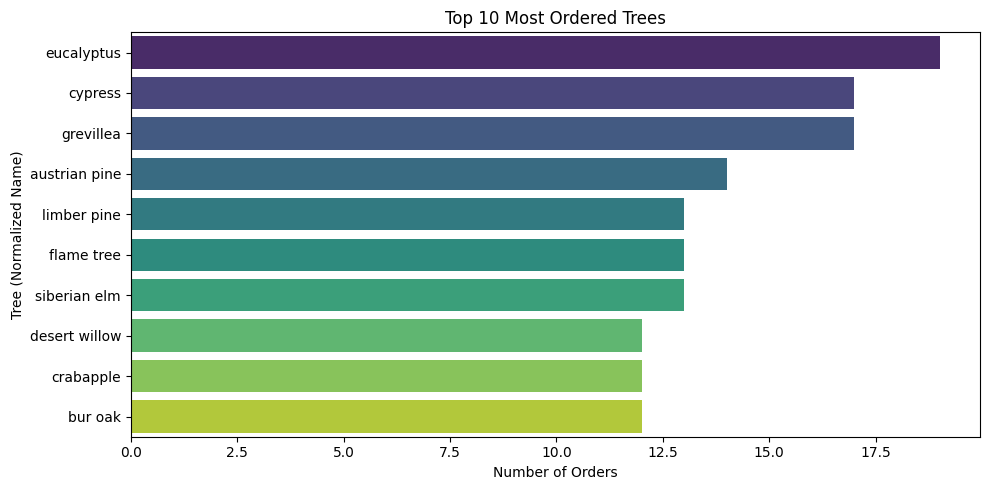

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

order_counts = orders['common_norm'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=order_counts.values, y=order_counts.index, palette='viridis')
plt.xlabel('Number of Orders')
plt.ylabel('Tree (Normalized Name)')
plt.title('Top 10 Most Ordered Trees')
plt.tight_layout()
plt.show()
